# 0.0. Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import boruta as bt
import seaborn as sns
import scipy
scipy.interp = np.interp

import scikitplot as skplt
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from imblearn.combine      import SMOTETomek

import xgboost as xgb

from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import linear_model as lm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score
from sklearn.naive_bayes import GaussianNB
import random
import warnings
warnings.filterwarnings('ignore')


## 0.1. Helper Functions

In [2]:
def plot_gains_and_lift_curve(y_val, yhat, model_name, axvline=None, ):
    fig, axs = plt.subplots(ncols= 2, figsize = (15,6))
    # Accumulative Gain
    skplt.metrics.plot_cumulative_gain(y_val, yhat, ax=axs[0],title=f'Cumulative Gain {model_name}');
    # Scikitplot library is there to help
    skplt.metrics.plot_lift_curve(y_val, yhat,ax=axs[1],title=f'Lift Curve {model_name}');
    
    if axvline != None:
        axs[0].axvline(axvline, 0, 1, color='green', ls='--', lw=2)
        axs[1].axvline(axvline, 0, 1, color='green', ls='--', lw=2)
        
def precision_at_k(data, k=20000):

    # reset_index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    

    return data.loc[k, 'precision_at_k']

def recall_at_k(data, k = 20000):
    # reset_index
    data = data.reset_index( drop = True)

    data['recall_at_k'] = data['response'].cumsum() / data ['response'].sum() 

    return data.loc[k, 'recall_at_k']

def cross_validation(model, x_train, y_train, data, k=5, Verbose = False):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    recall_list = []
    precision_k_list = []
    recall_k_list = []
    accuracy_list = []
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        
        if Verbose == True:
            
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model.fit(x_train_fold, y_train_fold)
        yhat = model.predict_proba(x_val_fold)
        yhat_1 = model.predict(x_val_fold)
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision_k = precision_at_k(data)
        precision_k_list.append(precision_k,)
        
        recall_k = recall_at_k(data)
        recall_k_list.append(recall_k)
        
        precision = precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)
        
        recall = recall_score(y_val_fold, yhat_1)
        recall_list.append(recall)

        accuracy = accuracy_score(y_val_fold, yhat_1)
        accuracy_list.append(accuracy)
            
        
        i+=1
        
    df = pd.DataFrame({'Model Name': type(model).__name__, 
                       'Accuracy Mean': np.mean(accuracy_list).round(4),
                       'Accuracy STD': np.std(accuracy_list).round(4),
                       'Precision Mean': np.mean(precision_list).round(4),
                       'Precision STD': np.std(precision_list).round(4),
                       'Recall Mean': np.mean(recall_list).round(4),
                       'Recall STD': np.std(recall_list).round(4),
                       'Precision@K Mean': np.mean(precision_k_list).round(4), 
                       'Precision@K STD': np.std(precision_k_list).round(4),
                       'Recall@K Mean': np.mean(recall_k_list).round(4), 
                       'Recall@K STD': np.std(recall_k_list).round(4)}, index = [0])

    return df

## 0.2. Loading Dataset

In [3]:
home = os.path.dirname(os.getcwd())
df_raw = pd.read_csv(os.path.join(home, 'data', 'raw', 'train.csv'))


In [4]:
df_raw.head()


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Descrição dos Dados

In [5]:
df1 = df_raw.copy()


## 1.1 Renomear colunas

In [6]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured',
            'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename
df1.columns = cols_new


## 1.2. Dimensão dos dados

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))


Number of Rows: 381109
Number of columns: 12


## 1.3. Tipos de dados

In [8]:
df1.dtypes


id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()


id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Dados Descritivos

In [10]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

num_attributes


,id,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,response
0,1,44,1,28.0,0,40454.0,26.0,217,1
1,2,76,1,3.0,0,33536.0,26.0,183,0
2,3,47,1,28.0,0,38294.0,26.0,27,1
3,4,21,1,11.0,1,28619.0,152.0,203,0
4,5,29,1,41.0,1,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...
381104,381105,74,1,26.0,1,30170.0,26.0,88,0
381105,381106,30,1,37.0,1,40016.0,152.0,131,0
381106,381107,21,1,30.0,1,35118.0,160.0,161,0
381107,381108,68,1,14.0,0,44617.0,124.0,74,0


In [11]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - sdt, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range',
             'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Engenharia de Atributos

In [12]:
df2 = df1.copy()


In [13]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else
                                                        'between_1_2_year' if x == '1-2 Year' else 'below_1_year')
# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(
    lambda x: 1 if x == 'Yes' else 0)


# 3.0. Filtragem dos dados


In [14]:
df3 = df2.copy()


# 4.0. Análise exploratória de dados

In [15]:
df4 = df3.copy()


## 4.1. Univariate Analysis

### 4.1.1 age

<Axes: xlabel='response', ylabel='age'>

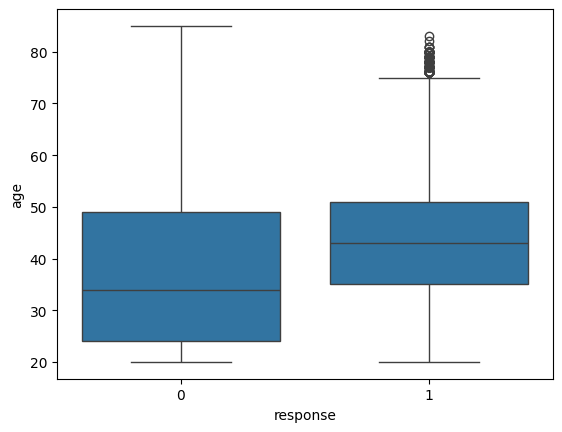

In [16]:

sns.boxplot(x='response', y='age', data=df4)


<Axes: xlabel='age', ylabel='Count'>

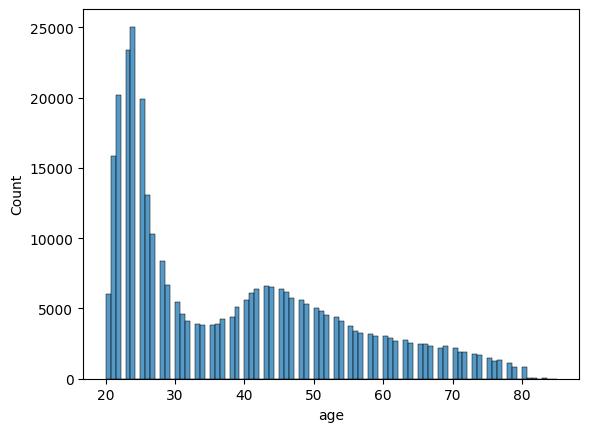

In [17]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00)

<Axes: xlabel='age', ylabel='Count'>

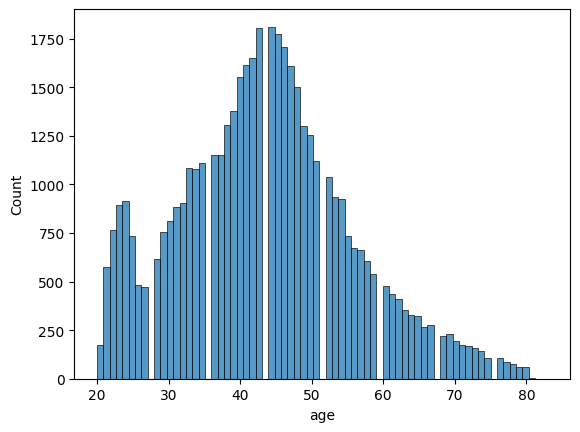

In [18]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux00)

### 4.1.2 annual_premium

<Axes: xlabel='response', ylabel='annual_premium'>

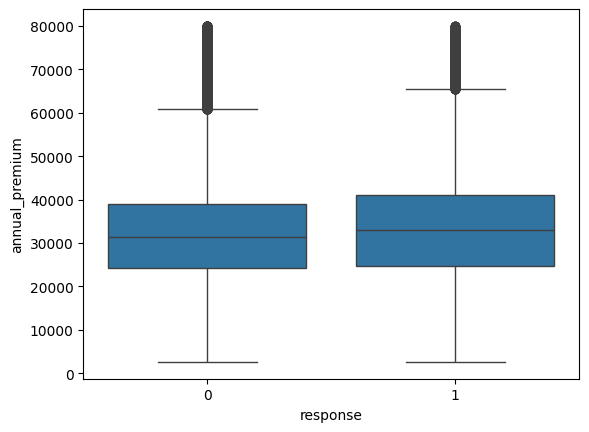

In [19]:

aux = df4[df4['annual_premium'] < 80000 ]
sns.boxplot(x='response', y='annual_premium', data=aux)

<Axes: xlabel='annual_premium', ylabel='Count'>

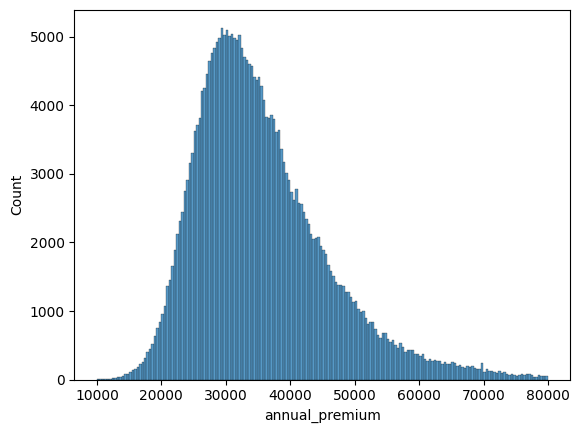

In [20]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux00)

<Axes: xlabel='annual_premium', ylabel='Count'>

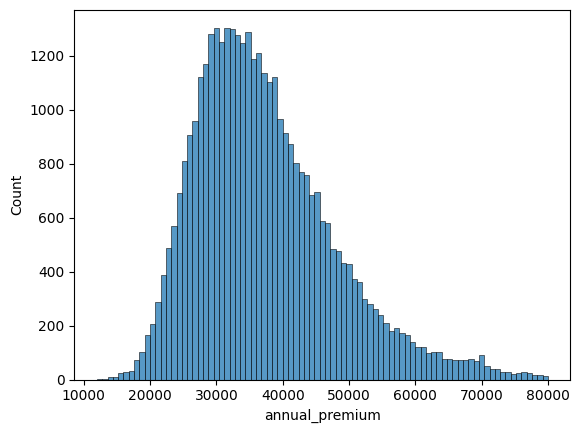

In [21]:
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux00)

### 4.1.3 driving license

<Axes: xlabel='response', ylabel='driving_license'>

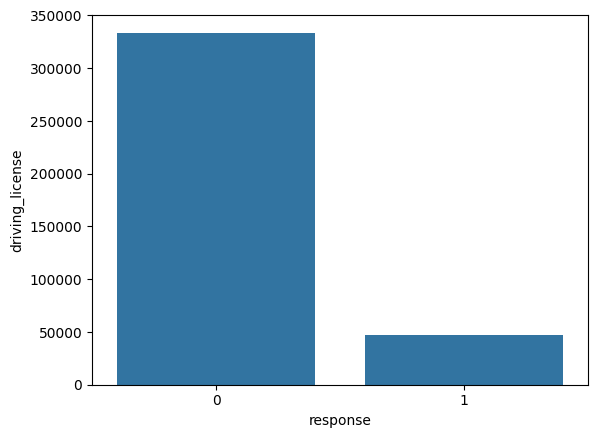

In [22]:
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux.head()
sns.barplot(x='response', y='driving_license', data=aux)

### 4.1.4 region code

<Axes: xlabel='region_code', ylabel='id'>

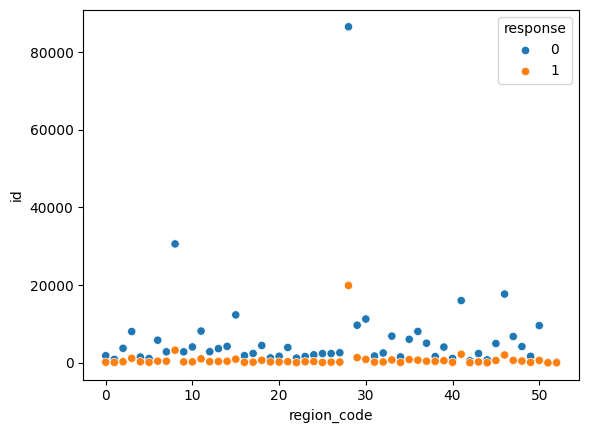

In [23]:
aux0 = df4[['id' ,'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux0)

### 4.1.5 previously insured

<Axes: xlabel='previously_insured', ylabel='id'>

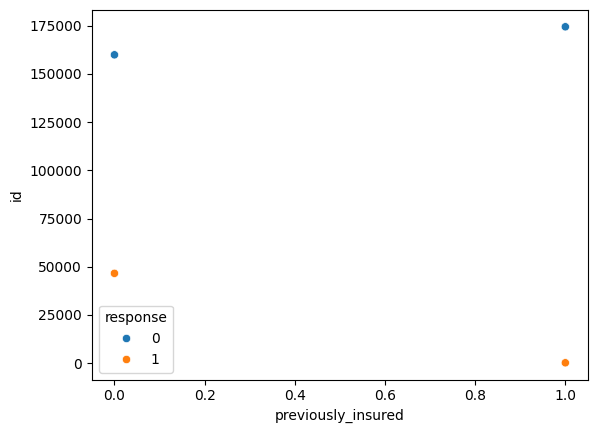

In [24]:
aux0 = df4[['id', 'previously_insured', 'response']].groupby( ['previously_insured', 'response'] ).count().reset_index()
sns.scatterplot( x='previously_insured', y='id', hue='response', data=aux0 )

In [25]:
pd.crosstab(df4['previously_insured'], df4['response'] ).apply(lambda x: x/x.sum(), axis=1 )


response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 4.1.6 vehicle age

In [26]:
pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: round((x/x.sum())*100, 2), axis = 'columns')

response,0,1
vehicle_age,,
below_1_year,95.63,4.37
between_1_2_year,82.62,17.38
over_2_years,70.63,29.37


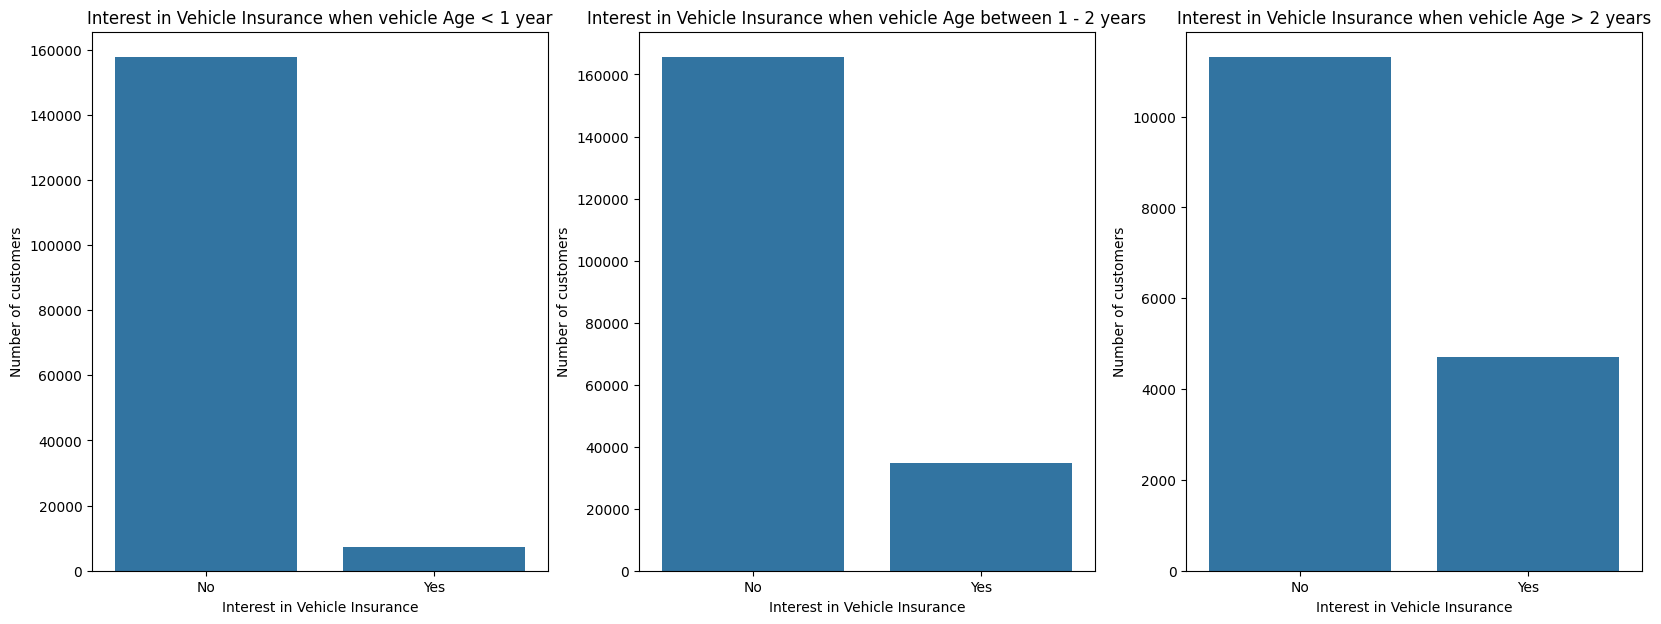

In [27]:
plt.rcParams["figure.figsize"] = (20, 7)

plt.subplot (1,3,1)
df_below = df4.loc[df4['vehicle_age'] == 'below_1_year']
int_below = df_below[['vehicle_age', 'response']].groupby('response').count().reset_index()
fig_below = sns.barplot (x = 'response', y='vehicle_age', data=int_below);
fig_below.set_xlabel('Interest in Vehicle Insurance')
fig_below.set_ylabel('Number of customers')
fig_below.set_title('Interest in Vehicle Insurance when vehicle Age < 1 year');
fig_below.set_xticklabels(['No', 'Yes']);

plt.subplot (1,3,2)
df_between = df4.loc[df4['vehicle_age'] == 'between_1_2_year']
int_between = df_between[['vehicle_age', 'response']].groupby('response').count().reset_index()
fig_between = sns.barplot (x = 'response', y='vehicle_age', data=int_between);
fig_between.set_xlabel('Interest in Vehicle Insurance')
fig_between.set_ylabel('Number of customers')
fig_between.set_title('Interest in Vehicle Insurance when vehicle Age between 1 - 2 years');

fig_between.set_xticklabels(['No', 'Yes']);

plt.subplot (1,3,3)
df_over = df4.loc[df4['vehicle_age'] == 'over_2_years']
int_over = df_over[['vehicle_age', 'response']].groupby('response').count().reset_index()

fig_over = sns.barplot (x = 'response', y='vehicle_age', data=int_over);
fig_over.set_xlabel('Interest in Vehicle Insurance')
fig_over.set_ylabel('Number of customers')
fig_over.set_title('Interest in Vehicle Insurance when vehicle Age > 2 years');

fig_over.set_xticklabels(['No', 'Yes']);

### 4.1.7. vehicle damage

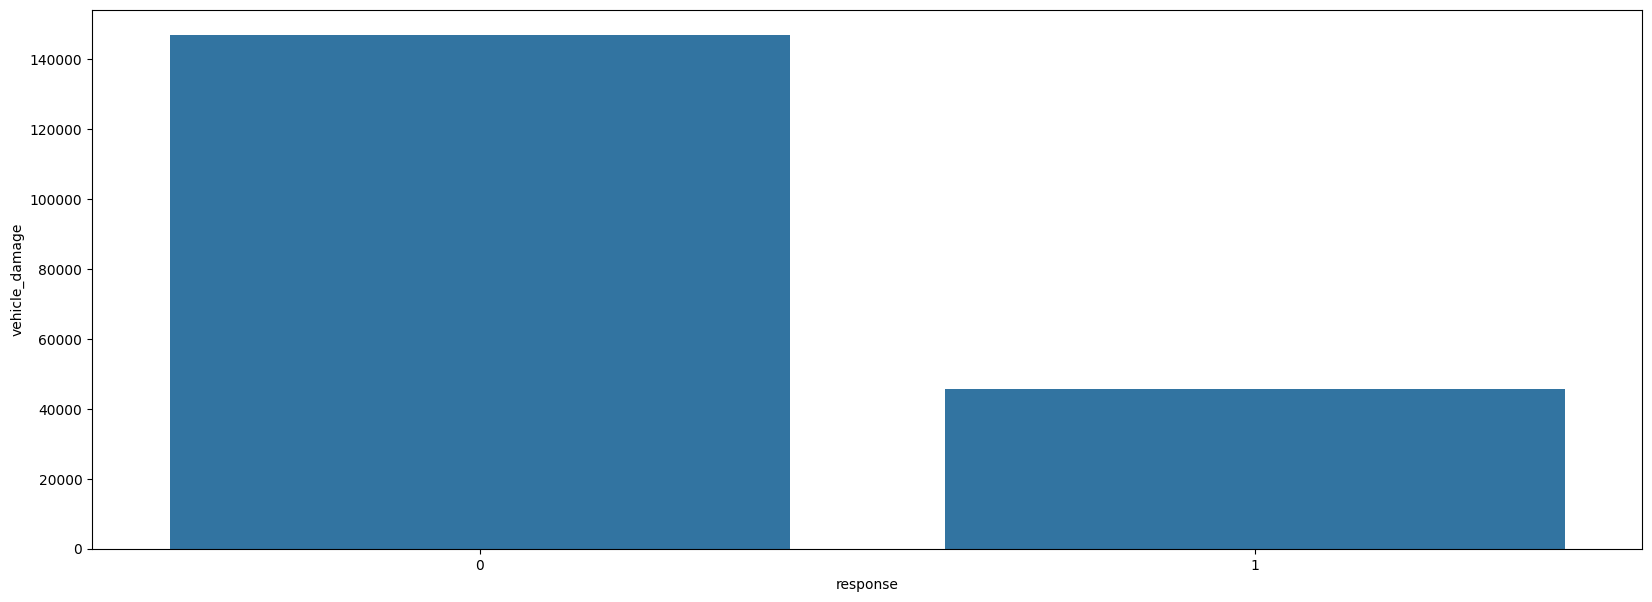

In [28]:
aux = df4[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

### 4.1.8 policy sales channel

<Axes: xlabel='response', ylabel='policy_sales_channel'>

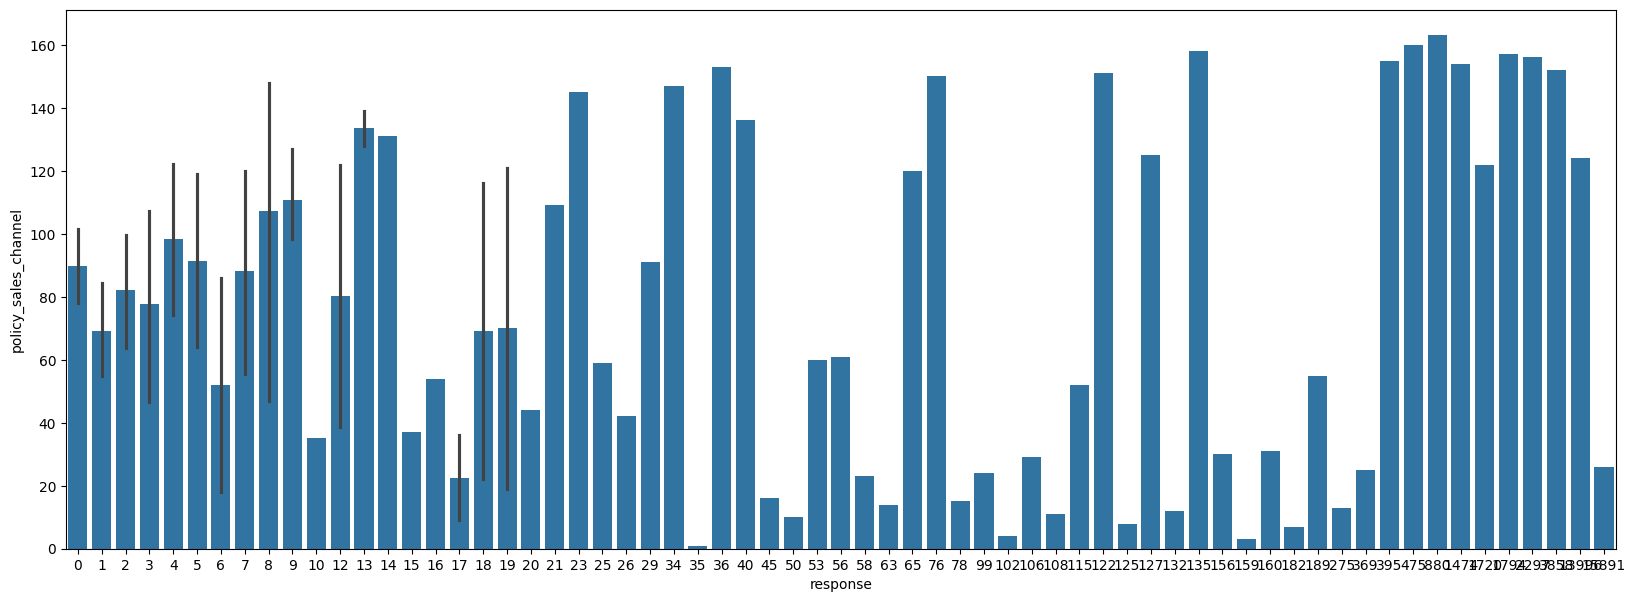

In [29]:
aux= df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux)

### 4.1.9 vintage

<Axes: xlabel='response', ylabel='vintage'>

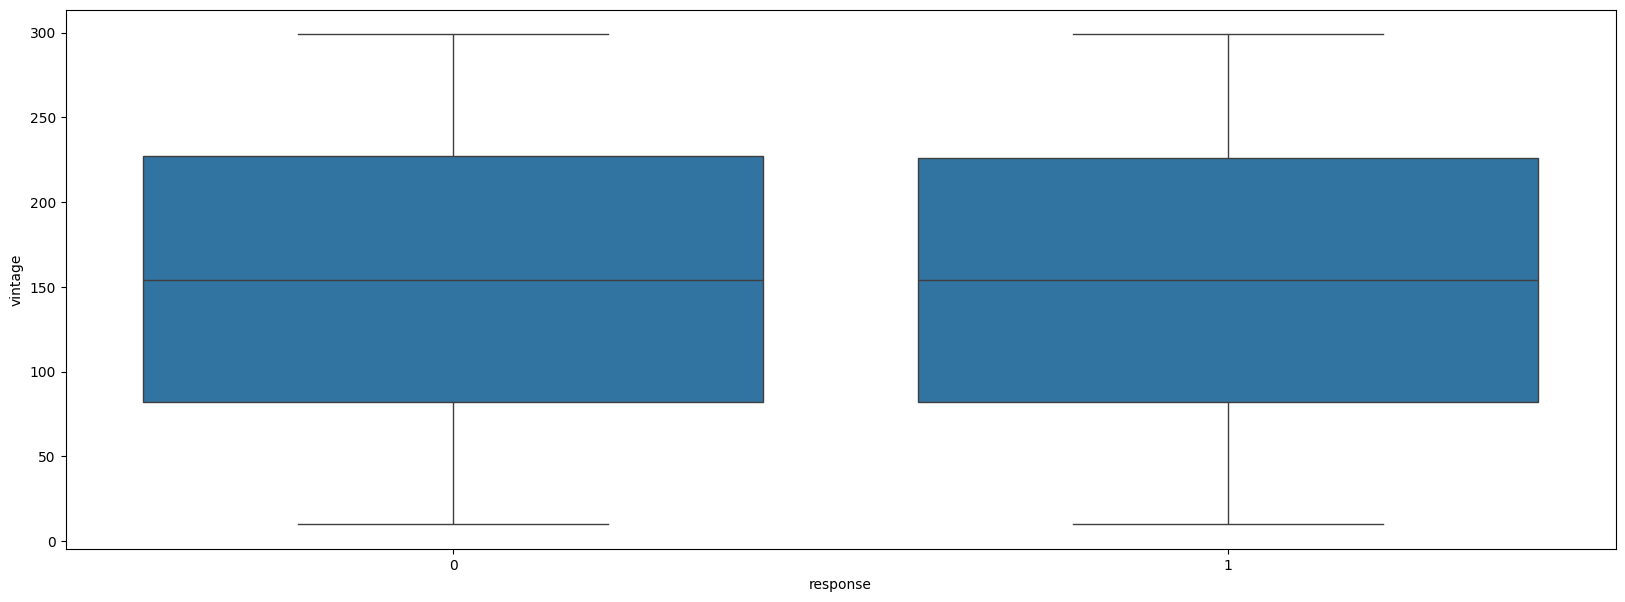

In [30]:
sns.boxplot(x='response', y='vintage', data=df4)


<Axes: xlabel='vintage', ylabel='Count'>

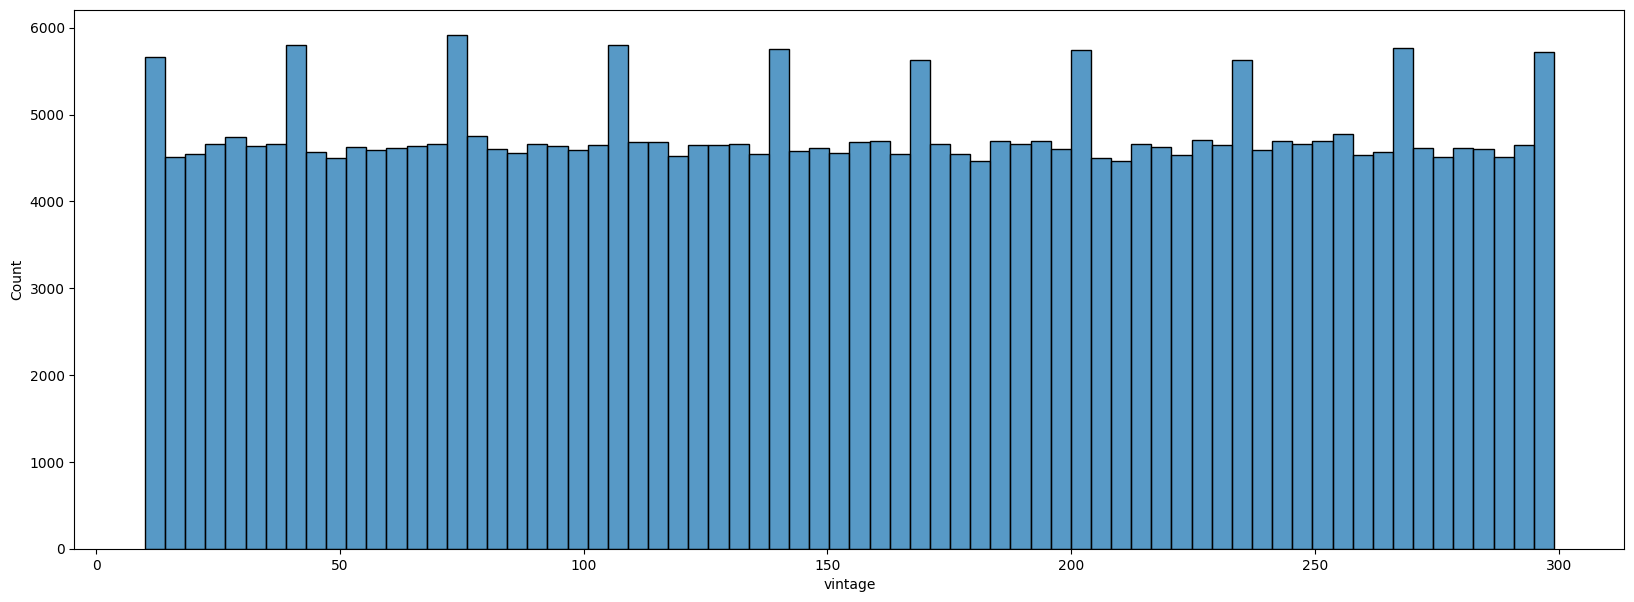

In [31]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00)

<Axes: xlabel='vintage', ylabel='Count'>

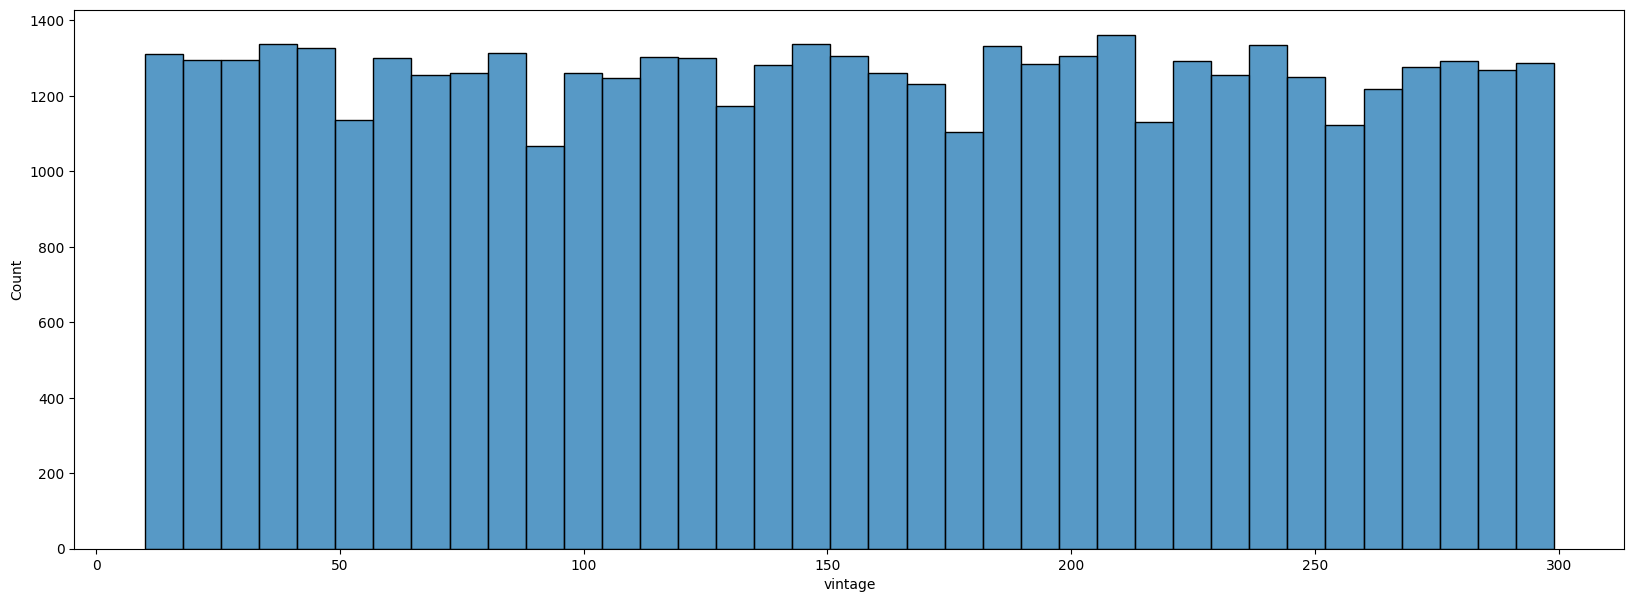

In [32]:
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux00)

# 5.0. Preparação dos dados


In [33]:
df5 = df4.copy()

In [34]:
df5['annual_premium'] = df5['annual_premium'].sort_values()

In [35]:
X = df5.drop(columns=['response'])
y = df5['response'].copy()

x_train, x_validation, y_train, y_valalidation = ms.train_test_split(X, y, test_size=0.20)
df5 = pd.concat([x_train, y_train], axis='columns')

## 5.1. Standardization

In [36]:
ss = pp.StandardScaler(with_mean=False)

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
# annual_premiun_scaler = pickle.dump(ss, open(os.path.join(home, 'src', 'features', 'annual_premiun_scaler.pkl'), 'wb'))

## 5.2. Rescaling

In [37]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
# age_scaler = pickle.dump(mms_age, open(os.path.join(home, 'src', 'features', 'age_scaler.pkl'), 'wb'))

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
# vintage_scaler = pickle.dump(mms_vintage, open( os.path.join(home, 'src', 'features', 'vintage_scaler.pkl'), 'wb'))

## 5.3. Transformação

### 5.3.1. Encoder

In [38]:
ohe_vehicle_age = pp.OneHotEncoder()

# gender - One hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
# pickle.dump(target_encode_gender, open( os.path.join(home, 'src', 'features', 'target_encode_gender_scaler.pkl'), 'wb'))

# region_code - Frenquency Encoding / Target Encoding / weighted Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code)
# pickle.dump(target_encode_region_code, open( os.path.join(home, 'src', 'features', 'target_encode_region_code_scaler.pkl'), 'wb'))

# vehicle_age - One Hot Endoding / Order Encode Frenquency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )
#pickle.dump(ohe_vehicle_age, open( os.path.join(home, 'src', 'features', 'vehicle_age_scaler.pkl'), 'wb'))


# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/ len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
# pickle.dump(fe_policy_sales_channel, open( os.path.join(home, 'src', 'features', 'fe_policy_sales_channel_scaler.pkl'), 'wb'))

## 5.4. Validation Preparation

In [39]:
# genger
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
#x_validation.loc[:, 'vehicle_age'] = ohe_vehicle_age.transform( x_validation[['vehicle_age']].values)
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_validation['annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation['vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

#fillna
x_validation = x_validation.fillna(0)

# 6.0. Seleção de variaveis


In [40]:
df6 = df5.copy()

## 6.1. Algoritmo Boruta

In [ ]:
x_train_n = df6.drop( ['id', 'response'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2 ).fit( x_train_n, y_train_n  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

## 6.1.1 Melhores Variaveis pelo Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

# Best featuers
X_train_fs = df6.drop(columns=['id', 'response'])
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['age']

## 6.2. Melhores Variáveis pela Importância das Arvores

In [ ]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.270494
0                annual_premium    0.244005
0                           age    0.167410
0                   region_code    0.107108
0                vehicle_damage    0.069031
0          policy_sales_channel    0.059299
0            previously_insured    0.055217
0      vehicle_age_below_1_year    0.013601
0  vehicle_age_between_1_2_year    0.005982
0                        gender    0.005087
0      vehicle_age_over_2_years    0.002295
0               driving_license    0.000471


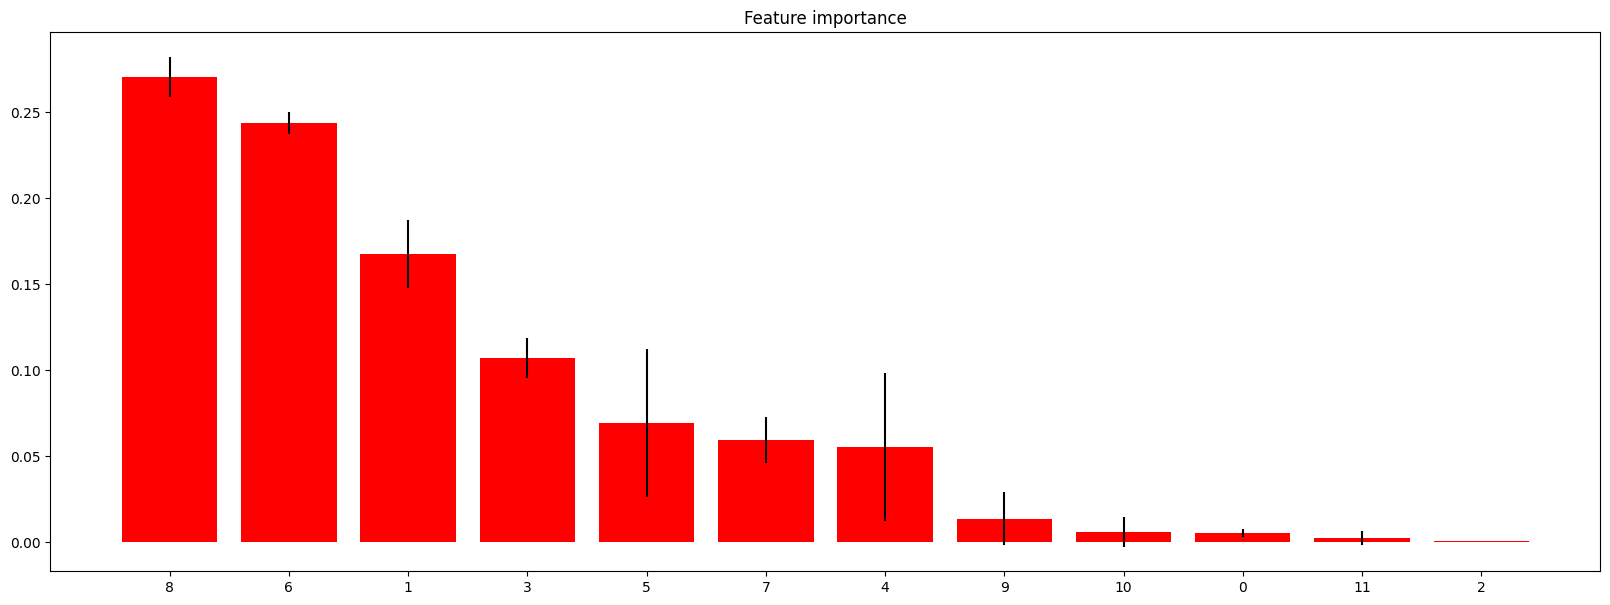

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# PLot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature importance')
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning Model

In [41]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'previously_insured', 'vehicle_damage', 'policy_sales_channel']

x_train = df6[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_valalidation.copy()

#resample
x_train_res, y_train_res = SMOTETomek(random_state = 42).fit_resample(x_train, y_train)

## 7.1. KNN Classifier

In [42]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(x_val)

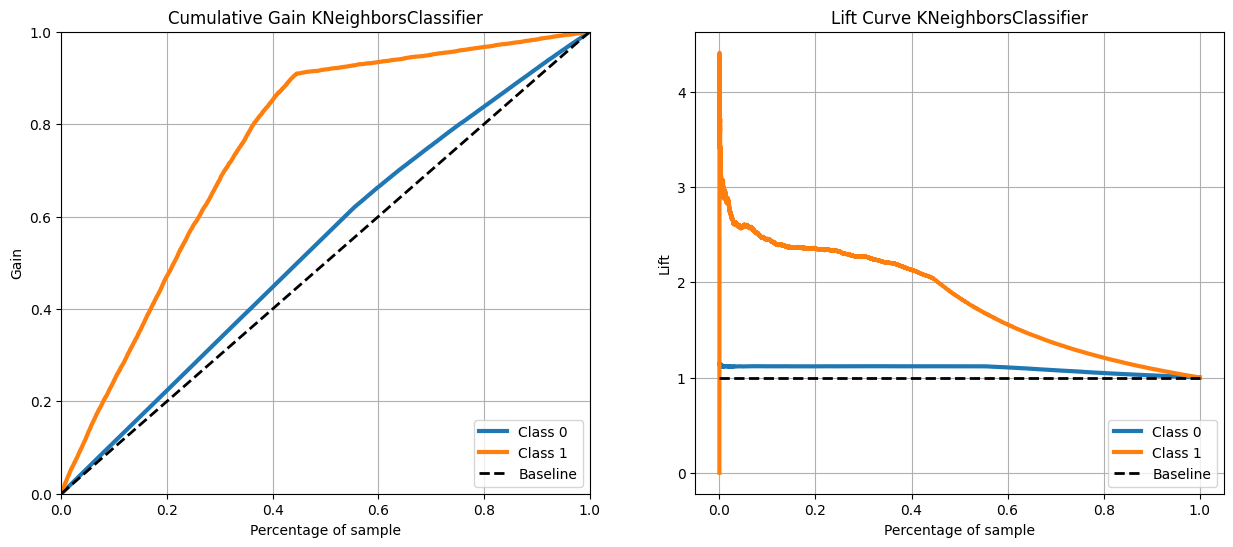

In [43]:
plot_gains_and_lift_curve(y_val, yhat_knn, type(knn_model).__name__)

## 7.2. logisticRegression

In [45]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train_res, y_train_res)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

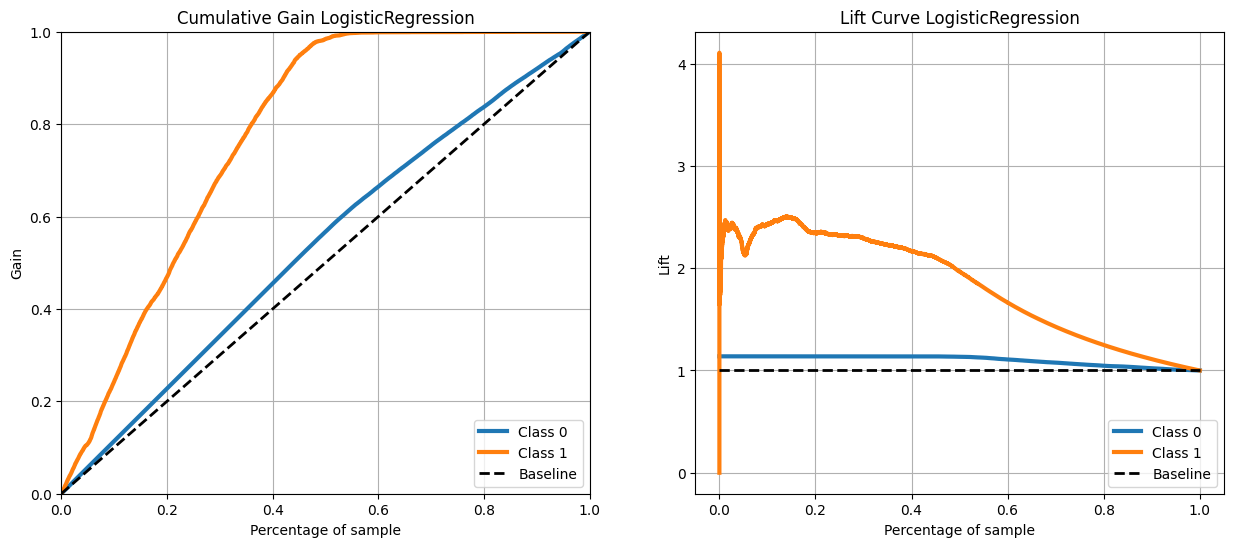

In [46]:
plot_gains_and_lift_curve(y_val, yhat_lr, type(lr_model).__name__)

## 7.3. Extra Trees Classifier

In [42]:
# model definition
et_model = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42)

# model fit
et_model.fit(x_train_res, y_train_res)

# model predict
yhat_et = et_model.predict_proba(x_val)

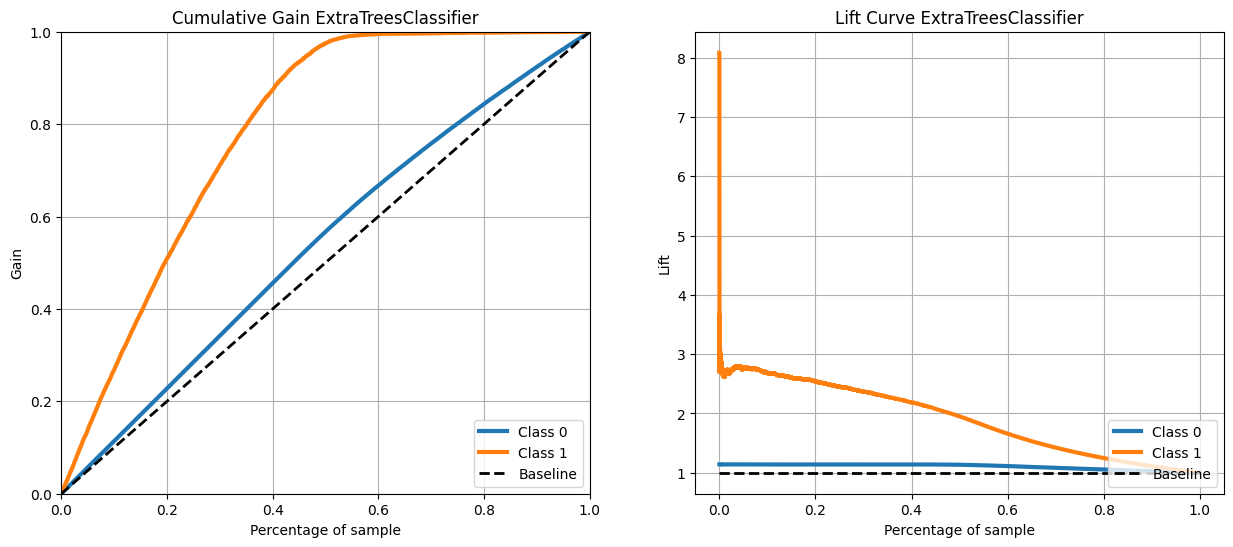

In [43]:
plot_gains_and_lift_curve(y_val, yhat_et, type(et_model).__name__)

## 7.4. Random Forest

In [ ]:
# model definition
rf_model = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# model training
rf_model.fit( x_train_res, y_train_res )

# model prediction
yhat_rf = rf_model.predict_proba( x_val )

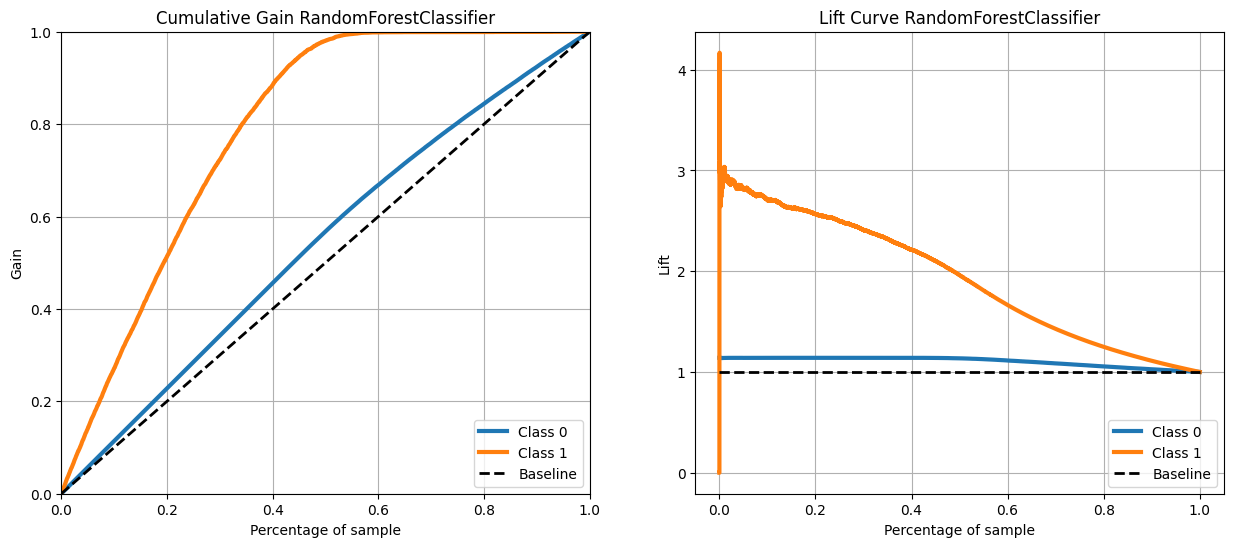

In [ ]:
plot_gains_and_lift_curve(y_val, yhat_rf, type(rf_model).__name__)

## 7.5. XGBoost Regressor 

In [45]:
model_xgb = xgb.XGBClassifier( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.03, 
                              max_depth=3, 
                              subsample=0.5, 
                              colsample_bytree=0.9,
                              min_child_weight=15)

# model training
model_xgb.fit(x_train_res, y_train_res);

# model prediction
yhat_xgb = model_xgb.predict_proba( x_val )

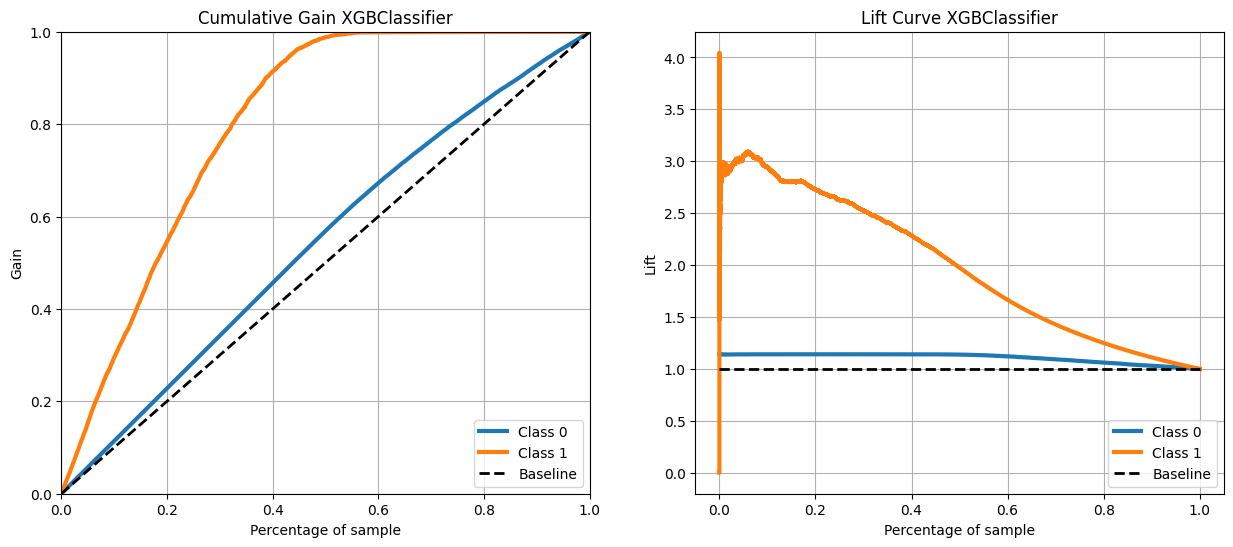

In [46]:
plot_gains_and_lift_curve(y_val, yhat_xgb, type(model_xgb).__name__)

## 7.6 Gaussian NB Classifier

In [ ]:
nb_model = GaussianNB()

# model training
nb_model.fit( x_train_res, y_train_res )

# model prediction
yhat_nb = nb_model.predict_proba( x_val )

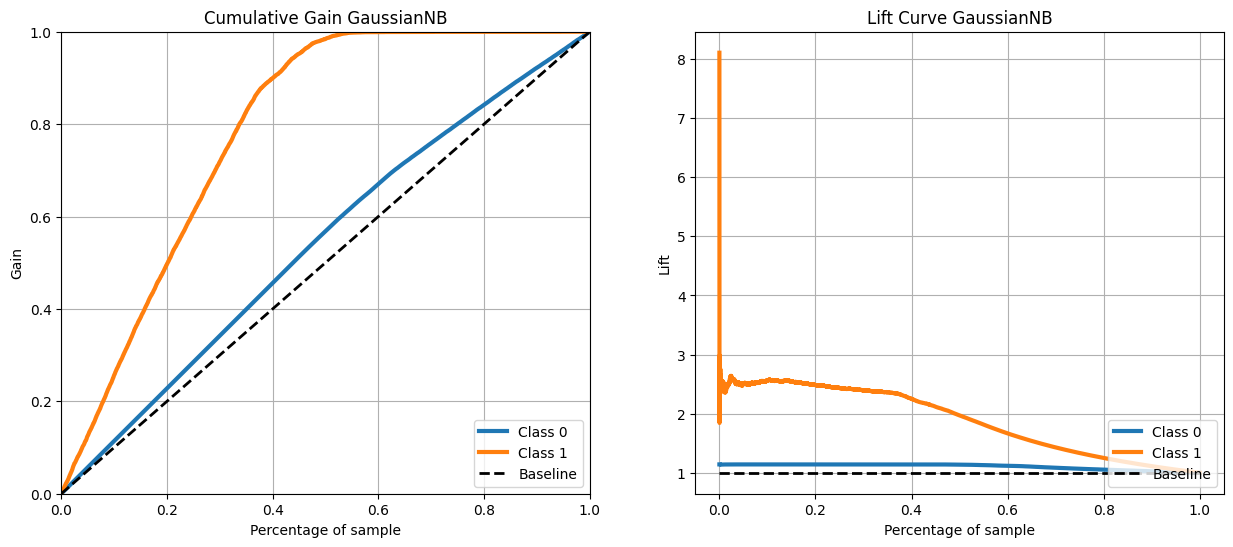

In [ ]:
plot_gains_and_lift_curve(y_val, yhat_nb, type(nb_model).__name__)

In [ ]:
#pickle.dump( model_xgb, open(os.path.join(home, 'src','models', 'model_xgb.pkl'), 'wb'))
# model_xgb = pickle.load(open(os.path.join(home, 'src', 'models', 'model_xgb.pkl'), 'rb' ))

#pickle.dump( lr_model, open(os.path.join(home, 'src','models', 'lr_model.pkl'), 'wb'))
# lr_model = pickle.load(open(os.path.join(home, 'src', 'models', 'lr_model.pkl'), 'rb' ))

#pickle.dump( knn_model, open(os.path.join(home, 'src','models', 'knn_model.pkl'), 'wb'))
# knn_model = pickle.load(open(os.path.join(home, 'src', 'models', 'knn_model.pkl'), 'rb' ))

# 8.0. Model Performance

In [ ]:
knn_val = cross_validation(knn_model, x_train_res, y_train_res, df6)
lr_val = cross_validation(lr_model, x_train_res, y_train_res, df6)
et_val = cross_validation(et_model, x_train_res, y_train_res, df6)
rf_val = cross_validation(rf_model, x_train_res, y_train_res, df6)
xgb_val = cross_validation(model_xgb, x_train_res, y_train_res, df6)
nb_val = cross_validation(nb_model, x_train_res, y_train_res, df6)

In [92]:
del y_valalidation

In [ ]:
results = pd.concat([knn_val,lr_val,et_val,rf_val,xgb_val,nb_val])
results.sort_values(by = 'Recall Mean', ascending = False)

,Model Name,Accuracy Mean,Accuracy STD,Precision Mean,Precision STD,Recall Mean,Recall STD,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,LogisticRegression,0.7889,0.0008,0.7096,0.0008,0.9781,0.0004,0.7623,0.0018,0.2902,0.0007
0,GaussianNB,0.7889,0.0008,0.7096,0.0008,0.9781,0.0004,0.7700,0.0028,0.2932,0.0011
0,KNeighborsClassifier,0.8625,0.0008,0.7951,0.0009,0.9767,0.0007,0.9177,0.0125,0.3494,0.0047
0,XGBClassifier,0.8093,0.0011,0.7389,0.0010,0.9569,0.0009,0.9491,0.0020,0.3614,0.0008
0,ExtraTreesClassifier,0.9264,0.0009,0.9059,0.0010,0.9516,0.0013,0.9982,0.0003,0.3801,0.0001
0,RandomForestClassifier,0.9218,0.0012,0.9170,0.0015,0.9277,0.0009,0.9998,0.0001,0.3807,0.0000


# 9.0. Hyperparameter Fine Tunning: 

In [ ]:
from sklearn.model_selection import GridSearchCV
model_xgb_cv = xgb.XGBClassifier(objective='reg:squarederror')

In [ ]:
param = {
    'colsample_bytree': [0.3, 0.7, 0.9],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'min_child_weight': [3, 8, 15],
    'n_estimators': [100, 200, 300],
    'subsample': [0.1, 0.5, 0.7],
    }

In [ ]:
clf = GridSearchCV(model_xgb_cv, param, cv = 3, verbose=3, scoring='precision')
clf.fit( x_train, y_train )

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
[CV 1/3] END colsample_bytree=0.3, eta=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1;, score=0.000 total time=   0.7s
[CV 2/3] END colsample_bytree=0.3, eta=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1;, score=0.000 total time=   0.7s
[CV 3/3] END colsample_bytree=0.3, eta=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1;, score=0.000 total time=   0.7s
[CV 1/3] END colsample_bytree=0.3, eta=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.5;, score=0.000 total time=   0.7s
[CV 2/3] END colsample_bytree=0.3, eta=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.5;, score=0.000 total time=   0.7s
[CV 3/3] END colsample_bytree=0.3, eta=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.5;, score=0.000 total time=   0.7s
[CV 1/3] END colsample_bytree=0.3, eta=0.01, max_depth=3, min_child_weight=3, 

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='reg:squarederror', ...),
             param_grid={'colsample_bytree': [0.3, 0.7, 0.9],
                         'eta': [0.01, 0.03], 'max_depth': [3, 5, 9],
                         'min_child_weight': [3, 8, 15],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.1, 0.5, 0.7]},
             scoring='precision', verbose=3)

In [ ]:
print(clf.best_params_)
yhat_xgb_cv = clf.predict_proba( x_val )

{'colsample_bytree': 0.9, 'eta': 0.03, 'max_depth': 9, 'min_child_weight': 15, 'n_estimators': 100, 'subsample': 0.1}


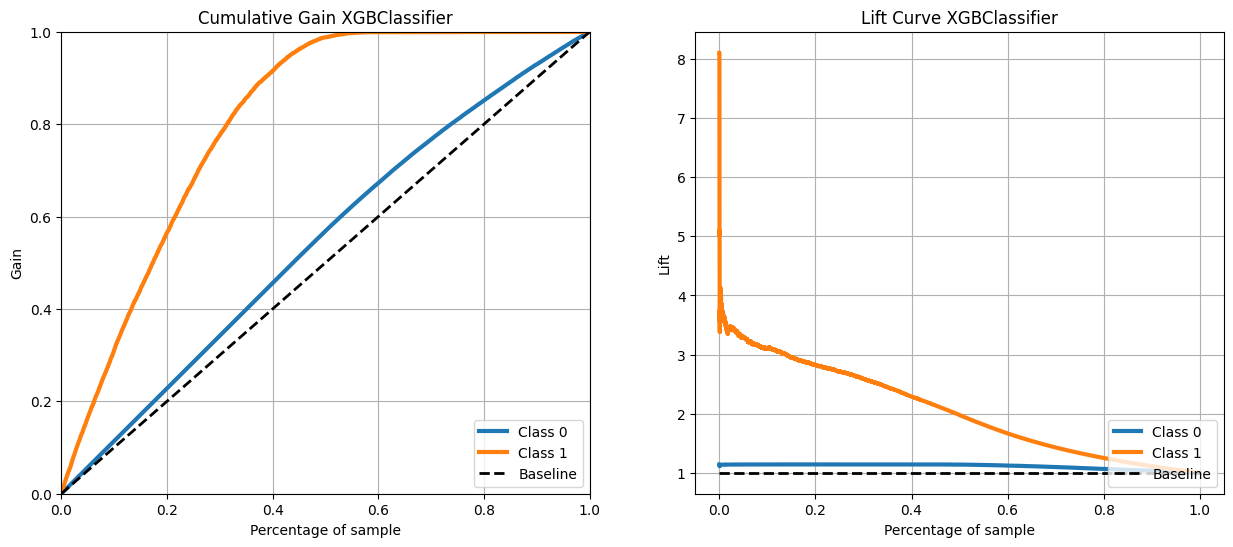

In [ ]:
# Accumulative Gain
plot_gains_and_lift_curve( y_val, yhat_xgb_cv, type(clf.best_estimator_).__name__ );

In [ ]:
# pickle.dump( clf, open(os.path.join(home, 'src','models', 'model_xgb_GridSearchCV.pkl'), 'wb'))
# clf = pickle.load(open(os.path.join(home, 'src', 'models', 'model_xgb_GridSearchCV.pkl'), 'rb' ))

# 10.0. Deploy to Production

In [ ]:
# Save trained model
# pickle.dump( lr_model, open(os.path.join(home, 'src','models', 'model_linear_regression.pkl'), 'wb'))


## 10.1. Health Insurance Classs

In [ ]:
class HealthInsurance:
    def __init__(self):
        self.home_path = os.path.dirname(os.getcwd())
        self.annual_premiun_scaler = pickle.load(open(os.path.join(self.home_path, 'src', 'features', 'annual_premiun_scaler.pkl'), 'rb'))
        self.age_scaler = pickle.load(open(os.path.join(self.home_path, 'src', 'features', 'age_scaler.pkl'), 'rb'))
        self.vintage_scaler = pickle.load(open(os.path.join(self.home_path, 'src', 'features', 'vintage_scaler.pkl'), 'rb'))
        self.target_encode_gender_scaler = pickle.load(open(os.path.join(self.home_path, 'src', 'features', 'target_encode_gender_scaler.pkl'), 'rb'))
        self.target_encode_region_code_scaler = pickle.load(open(os.path.join(self.home_path, 'src', 'features', 'target_encode_region_code_scaler.pkl'), 'rb'))
        self.fe_policy_sales_channel_scaler = pickle.load(open(os.path.join(self.home_path, 'src', 'features', 'fe_policy_sales_channel_scaler.pkl'), 'rb'))


    def data_cleaning(self,data):    
        ## 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured',
                    'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage']
    
        data.columns = cols_new
        return data

    def feature_engineering(self, data):
        # vehicle age
        data['vehicle_age'] = data['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else
                                                                'between_1_2_year' if x == '1-2 Year' else 'below_1_year')
        # vehicle damage
        data['vehicle_damage'] = data['vehicle_damage'].apply(
            lambda x: 1 if x == 'Yes' else 0)
        return data

    def data_preparation(self, data):
        # annual_premium
        data['annual_premium'] = self.annual_premiun_scaler.transform(data[['annual_premium']].values)

        # Age
        data['age'] = self.age_scaler.transform(data[['age']].values)

        # vintage
        data['vintage'] = self.vintage_scaler.transform(data[['vintage']].values)

        # gender
        data.loc[:, 'gender'] = data['gender'].map( self.target_encode_gender_scaler )

        # region_code
        data.loc[:, 'region_code'] = data['region_code'].map( self.target_encode_region_code_scaler)

        # vehicle_age
        data = pd.get_dummies(data, prefix='vehicle_age', columns=['vehicle_age'])

        # policy_sales_channel
        data.loc[:, 'policy_sales_channel'] = data['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)


        cols_selected = ['annual_premium', 'vintage','age', 'region_code', 'vehicle_damage', 'previously_insured','policy_sales_channel']

        return data[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # model prediction
        pred = model.predict_proba(test_data)
        # join prediction into original data
        original_data['response'] = pred[:, 0].tolist()

        return original_data #original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# loading model
home_path = os.getcwd()

model = pickle.load(open(os.path.join(home_path, 'models', 'model_linear_regression.pkl'), 'rb' ))

# initialize API
app = Flask(__name__)

@app.route('/predict', methods['POST'])
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate HealthInsurance class 
        pipeline = HealthInsurance()

        # data cleaning
        data = pipeline.data_cleaning(test_raw)

        # feature engineering
        data = pipeline.feature_engineering(data)

        # data preparation
        data = pipeline.data_preparation(data)

        # prediction
        data_response = pipeline.get_prediction(model, test_raw, data)

        return data_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json')

if __mane__ == '__main__':
    app.run( '0.0.0.0')

## 10.3. API Teste

In [ ]:
import requests
import json
import pandas as pd
import os

In [ ]:
# loading test dataset
home = os.path.dirname(os.getcwd())
df_test = pd.read_csv(os.path.join(home, 'data', 'processed', 'df_test.csv'))

In [ ]:
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
print(df_test.columns)
['id', 'Gender', 'Age', 'driving_license', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage']

In [ ]:
url = 'http://0.0.0.0:5000/predict'
#url = 'https://health-insurance-dso.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d10 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d10.sort_values('response', ascending=False).head(10)

# 11. Business and Financial Results

In [70]:
#x_val = pickle.load(open(os.path.join(home, 'data', 'processed', 'x_val.pkl'), 'rb' ))
#y_val = pickle.load(open(os.path.join(home, 'data', 'processed', 'y_val.pkl'), 'rb' ))
model = pickle.load(open(os.path.join(home, 'data', 'models', 'model_xgb.pkl'), 'rb' ))
yhat = model.predict_proba(x_val)

### 11.1. Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

In [71]:
df11 = x_val.copy()
# join prediction into original data
df11['response'] = yhat[:, 1].tolist()
df11['percent'] = yhat[:, 0].tolist()

In [72]:
df11.head()

,annual_premium,vintage,age,region_code,previously_insured,vehicle_damage,policy_sales_channel,response,percent
153474,2.306624,0.989619,0.107692,0.134681,1,0,0.354295,0.058262,0.941738
19280,0.152934,0.560554,0.400000,0.094569,0,1,0.000446,0.685355,0.314645
287359,1.610747,0.242215,0.030769,0.087352,1,1,0.354295,0.090440,0.909560
380929,1.684946,0.913495,0.076923,0.080226,0,1,0.193832,0.593394,0.406606
201168,2.095483,0.062284,0.169231,0.186194,0,0,0.354295,0.254995,0.745005


In [73]:
df11 = df11.sort_values('response', ascending=False)

In [74]:
percennt_at_20k = 20000/ len(df11)
percennt_at_20k

0.2623914355435439

In [75]:
recall_at_k(df11, k=20000)

np.float64(0.5417243241770336)

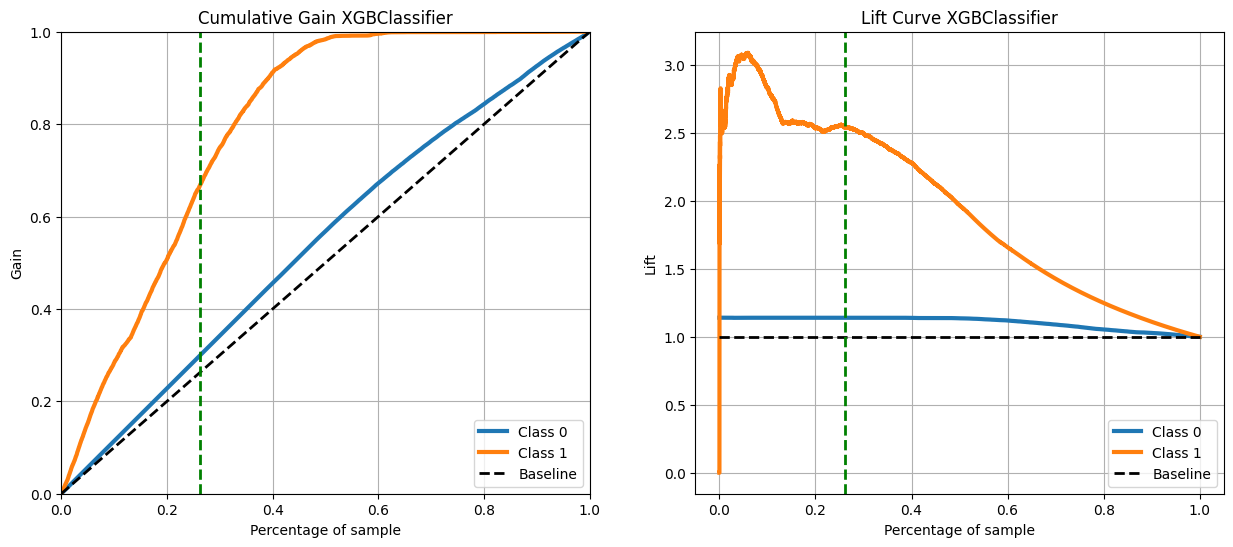

In [76]:
plot_gains_and_lift_curve(y_val, yhat, type(model).__name__, axvline=percennt_at_20k)

### 11.2. E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

In [77]:
percennt_at_40k = 40000/ len(df11)
percennt_at_40k

0.5247828710870878

In [78]:
recall_at_k(df11, k=40000)

np.float64(0.9107494245664104)

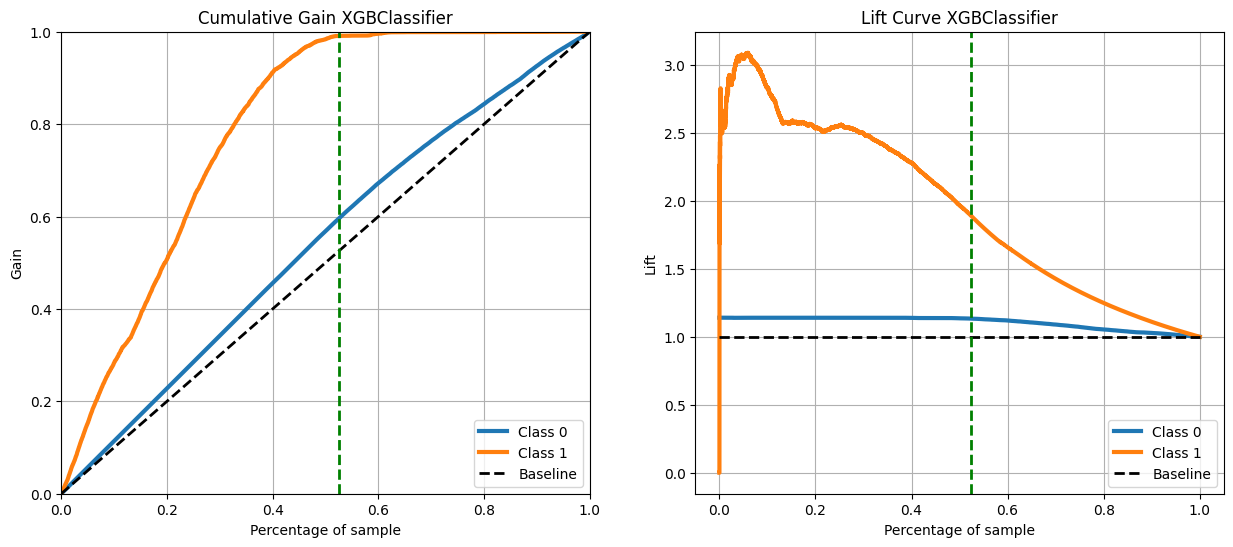

In [79]:
plot_gains_and_lift_curve(y_val, yhat, type(model).__name__,axvline=percennt_at_40k)

### 11.3. Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

In [80]:
# # reset_index
df11 = df11.reset_index(drop=True)
# # create ranking order
df11['ranking'] = df11.index + 1

# #len(df11['ranking']) * .8009

In [81]:
df11['recall_at_k'] = df11['response'].cumsum() / df11 ['response'].sum() 
id_at_80 = df11.loc[df11['recall_at_k'] >= 0.8]['ranking'].min()
percennt_at_80 = id_at_80/ len(df11)


In [82]:
percennt_at_80

np.float64(0.41898664427593085)

In [83]:
recall_at_k(df11, k=id_at_80)

np.float64(0.8000259713418056)

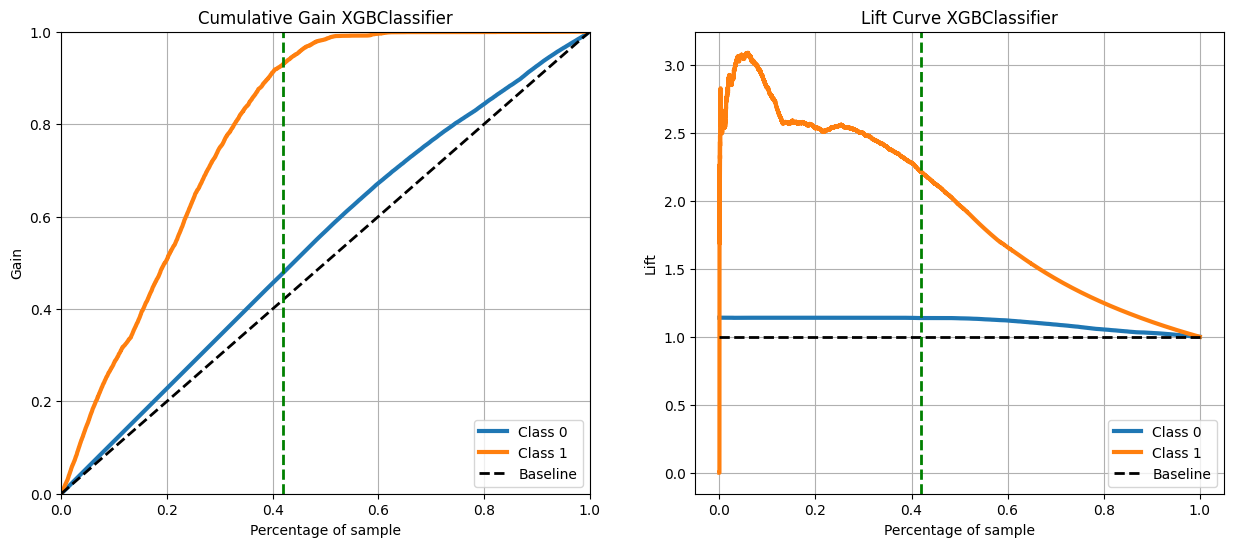

In [84]:
plot_gains_and_lift_curve(y_val, yhat, type(model).__name__,axvline=percennt_at_80)